In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
### Step 1: Prepare MNIST Dataset with digits 1 and 8
def prepare_mnist_data(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    digit_1_indices = [i for i, (img, label) in enumerate(mnist) if label == 1][:5000]
    digit_8_indices = [i for i, (img, label) in enumerate(mnist) if label == 8][:5000]

    selected_indices = digit_1_indices + digit_8_indices

    subset = Subset(mnist, selected_indices)

    images = []
    labels = []

    for img, label in subset:
        images.append(img.view(-1))
        labels.append(label)

    images = torch.stack(images)
    labels = torch.tensor(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.3, random_state=seed, stratify=labels
    )

    return X_train, X_test, y_train, y_test

In [3]:
## Step 2: Linear PCA Function
def perform_pca(X_train, X_test, M=2):

    if isinstance(X_train, torch.Tensor):
        X_train = X_train.numpy()
    if isinstance(X_test, torch.Tensor):
        X_test = X_test.numpy()

    x_bar = np.mean(X_train, axis=0)
    X_train_centered = X_train - x_bar
    X_test_centered = X_test - x_bar

    N = X_train_centered.shape[0]
    Sigma = (1 / N) * X_train_centered.T @ X_train_centered

    V, Lambda, _ = np.linalg.svd(Sigma)

    V_M = V[:, :M]
    Z_train = X_train_centered @ V_M
    Z_test = X_test_centered @ V_M

    return Z_train, Z_test, V_M, x_bar

In [12]:
## Step 3: Reconstruct from Linear PCA
def reconstruct_from_pca(Z, V_M, x_bar):
    return Z @ V_M.T + x_bar

def show_original_vs_reconstructed(X_orig, X_recon, num_images=10):
    plt.figure(figsize=(2 * num_images, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_orig[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(X_recon[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.suptitle("Original vs Linear PCA-Reconstructed Images")
    plt.tight_layout()
    plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.82MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.58MB/s]


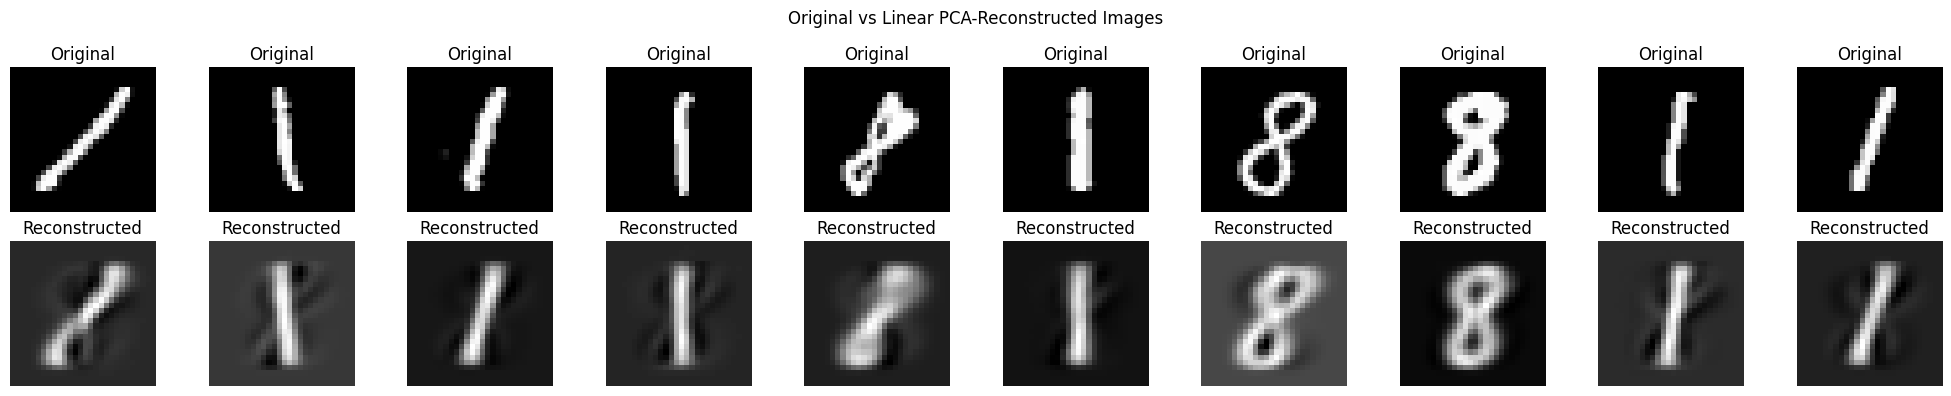

In [8]:
X_train, X_test, y_train, y_test = prepare_mnist_data()
Z_train, Z_test, V_M, x_bar = perform_pca(X_train, X_test, M=10)

X_train_recon = reconstruct_from_pca(Z_train, V_M, x_bar)
show_original_vs_reconstructed(X_train, X_train_recon, num_images=10)

In [13]:
## Evaluation of Reconstructed Images
def evaluate_reconstruction_mse(X_orig, X_recon):
    return np.mean((X_orig - X_recon) ** 2)

def plot_mse_curve(mse_list, method_name):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), mse_list, marker='o', label=method_name)
    plt.xlabel("M (Number of Components)")
    plt.ylabel("Test MSE")
    plt.title(f"Test MSE vs. M for {method_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

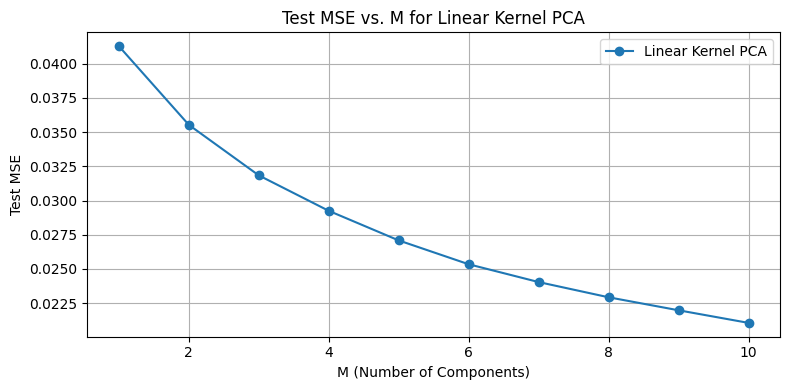

In [10]:
mse_scores = []
X_train, X_test, y_train, y_test = prepare_mnist_data()

for i in range(1, 11):
  Z_train, Z_test, V_M, x_bar = perform_pca(X_train, X_test, M=i)

  X_test_recon = reconstruct_from_pca(Z_test, V_M, x_bar)
  test_mse = mean_squared_error(X_test, X_test_recon)
  mse_scores.append(test_mse)

plot_mse_curve(mse_scores, method_name=f"Linear Kernel PCA")

In [6]:
## Tuning for RBF and Poly Kernel PCA
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, linear_kernel
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def rbf_kernel(X, gamma):
    sq_dists = euclidean_distances(X, X, squared=True)
    return np.exp(-gamma * sq_dists)

def poly_kernel(X, c):
    return (linear_kernel(X, X) + c) ** 3

def center_kernel(K):
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    return K_centered

def kernel_pca(K_centered, M):
    eigvals, eigvecs = np.linalg.eigh(K_centered)

    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    alphas = eigvecs[:, :M]
    lambdas = eigvals[:M]
    return alphas, lambdas

def compute_kernel_scores(K_centered, alphas):
    return K_centered @ alphas

def center_test_kernel(K_test, K_train):
    N_train = K_train.shape[0]

    K_train_mean_row = K_train.mean(axis=0)
    K_train_mean_total = K_train.mean()

    K_test_mean_row = K_test.mean(axis=1, keepdims=True)

    K_test_centered = (
        K_test
        - K_train_mean_row[np.newaxis, :]
        - K_test_mean_row
        + K_train_mean_total
    )

    return K_test_centered

def tune_rbf_gamma_train_test(X_train, y_train, X_test, y_test, gamma_list, M=10):
    best_acc = -np.inf
    best_gamma = None
    for gamma in gamma_list:
        K_train = rbf_kernel(X_train, gamma)
        Kc_train = center_kernel(K_train)
        alphas, _ = kernel_pca(Kc_train, M)
        Z_train = compute_kernel_scores(Kc_train, alphas)

        K_test = np.exp(-euclidean_distances(X_test, X_train, squared=True) * gamma)
        K_test_centered = center_test_kernel(K_test, K_train)
        Z_test = K_test_centered @ alphas

        clf = LogisticRegression(max_iter=1000)
        clf.fit(Z_train, y_train)
        y_pred = clf.predict(Z_test)

        acc = clf.score(Z_test, y_test)
        if acc > best_acc:
            best_acc = acc
            best_gamma = gamma

        tn, fp, fn, tp = confusion_matrix(y_test_bin, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print(f"Accuracy: {acc:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")

    return best_gamma

def tune_poly_c_train_test(X_train, y_train, X_test, y_test, c_list, M=10):
    best_acc = -np.inf
    best_c = None
    for c in c_list:
        K_train = poly_kernel(X_train, c)
        Kc_train = center_kernel(K_train)
        alphas, _ = kernel_pca(Kc_train, M)
        Z_train = compute_kernel_scores(Kc_train, alphas)

        K_test = (X_test @ X_train.T + c) ** 3
        K_test_centered = center_test_kernel(K_test, K_train)
        Z_test = K_test_centered @ alphas

        clf = LogisticRegression(max_iter=1000)
        clf.fit(Z_train, y_train)
        y_pred = clf.predict(Z_test)

        acc = clf.score(Z_test, y_test)
        if acc > best_acc:
            best_acc = acc
            best_c = c

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print(f"Accuracy: {acc:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")

    return best_c

In [ ]:
X_train, X_test, y_train, y_test = prepare_mnist_data()
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()

gamma_vals = [1e-4, 1e-3, 1e-2, 1e-1]
best_gamma = tune_rbf_gamma_train_test(X_train_np, y_train_np, X_test_np, y_test_np, gamma_vals)
print(f"Best gamma for RBF kernel: {best_gamma}")

c_vals = [0.1, 1, 5, 10, 50]
best_c = tune_poly_c_train_test(X_train_np, y_train_np, X_test_np, y_test_np, c_vals)
print(f"Best c for Polynomial kernel: {best_c}")

Best gamma for RBF kernel: 0.01
Best c for Polynomial kernel: 10


In [7]:
##Test accuracies on different PCA techniques
def linear_train_test(X_train_np, y_train_np, X_test_np, y_test_np, M=10):
  Z_train, Z_test, V_M, x_bar = perform_pca(X_train_np, X_test_np, M=M)

  clf = LogisticRegression(max_iter=1000)
  clf.fit(Z_train, y_train)

  y_pred = clf.predict(Z_test)

  acc = clf.score(Z_test, y_test)

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  print(f"Accuracy: {acc:.4f}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")

  return acc

In [9]:
gamma_vals = [1e-2]
c_vals = [10]

X_train, X_test, y_train, y_test = prepare_mnist_data()
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()

y_train_bin = (y_train_np == 1).astype(int)
y_test_bin = (y_test_np == 1).astype(int)

acc = tune_rbf_gamma_train_test(X_train_np, y_train_bin, X_test_np, y_test_bin, gamma_vals, M=8)

Accuracy: 0.9757, TPR: 0.9767, FPR: 0.0253


In [10]:
acc = linear_train_test(X_train_np, y_train_bin, X_test_np, y_test_bin, M=10)

Accuracy: 0.9770, TPR: 0.9720, FPR: 0.0180


In [11]:
acc = tune_poly_c_train_test(X_train_np, y_train_bin, X_test_np, y_test_bin, c_vals, M=6)

Accuracy: 0.9670, TPR: 0.9753, FPR: 0.0413
